In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from cbsim.net import Net
from cbsim.request import Request
from cbsim.stochastic import Stochastic

from cbsim.experiment import sample_stats
from cbsim.experiment import chi_square_norm

<H1>Simulate demand

<H2>Load network and inlet flows

In [10]:
net = Net()
net.load_from_file(fnodes='ss-nodes.csv', flinks='ss-links.csv')

days = 6 # 7:00am-11:30am
fdata = {
    0: [[114, 108, 107, 51, 139, 114], [15, 11, 7, 5, 8, 2]],   # Calle San Juan
    1: [[103, 102, 88, 35, 118, 101], [17, 7, 6, 13, 10, 9]],   # Calle Inigo
    10: [[130, 127, 106, 47, 117, 78], [3, 11, 7, 5, 14, 18]],  # Boulevard
    21: [[47, 23, 43, 21, 45, 35], [25, 33, 27, 19, 42, 19]]    # Calle Ijentea
}
loadpoints = {0: 'A', 21: 'B'}
outlets = [3, 6, 19]

flows = {}
for f in fdata:
    d = fdata[f]
    flows[f] = int(np.array([d[0][i] + d[1][i] for i in range(days)]).mean()) # MEAN
_total = sum(flows.values()) # total number of requests to generate

probs = { 'R': 1, 'H': 1, 'S': 1, 'P': 1, 'W': 1 }
# probs = { 'R': 0.2, 'H': 0.05, 'S': 0.2, 'P': 0.15, 'W': 0.05 }

clients = [nd for nd in net.nodes if nd.type != 'N' and nd.type != 'L']
entries = sorted(flows.keys())

net.auto_regions(entries)
net.set_regions()

zones = sorted([r.code for r in net.regions])

print(flows, _total)

{0: 113, 1: 101, 10: 110, 21: 63} 387


In [11]:
_total / len(zones)**2, net.regions

(24.1875,
 [Zone 1: [-1.9845347752808995, 43.32410137078651], 89 nodes,
  Zone 2: [-1.9833162368421056, 43.323416473684205], 38 nodes,
  Zone 3: [-1.9845154123711335, 43.32300159793813], 97 nodes,
  Zone 4: [-1.986359784810126, 43.3229742658228], 79 nodes])

In [12]:
def sim_diff():
    # 1) generate requests
    generated = 0
    reqs = []
    while generated < _total:
        dst = np.random.choice(clients)
        if np.random.random() < probs[dst.type]:
            req = Request(0, None, dst)
            generated += 1
            reqs.append(req)

    # 2) generate demand using traditionial aproach
    net.demand = net.gen_demand(flows=flows, 
                                probs=probs,
                                requests=reqs,
                                s_weight=Stochastic(),
                                traditional=True)
    # calculate ODM
    odm1 = np.matrix([[0 for zone in zones] for entry in entries])
    for r in net.demand:
        i = entries.index(r.origin.nid)
        j = r.destination.region.code
        odm1[i, j] += 1
    # print(odm1)
    # print([odm1[i,:].sum() for i in range(odm1.shape[0])], odm1.sum(), 'prod')
    # print([odm1[:,i].sum() for i in range(odm1.shape[1])], odm1.sum(), 'attr')

    # 3) generate demand using the proposed aproach
    net.demand = net.gen_demand(flows=flows, 
                                probs=probs,
                                requests=reqs,
                                s_weight=Stochastic(),
                                traditional=False)
    # calculate ODM
    odm2 = np.matrix([[0 for zone in zones] for entry in entries])
    for r in net.demand:
        i = entries.index(r.origin.nid)
        j = r.destination.region.code
        odm2[i, j] += 1
    # print(odm2)
    # print([odm2[i,:].sum() for i in range(odm2.shape[0])], odm2.sum(), 'prod')
    # print([odm2[:,i].sum() for i in range(odm2.shape[1])], odm2.sum(), 'attr')

    # 4) calculate difference matrix
    odm = np.abs(odm1 - odm2)
    
    return odm1.mean(), odm1.std(), odm2.mean(), odm2.std(), odm.mean(), odm.std()

In [13]:
rfile = open('demand_sim_ss_mid.txt', 'w')

for i in range(300):
    res = sim_diff()
    print(i + 1, res)
    rfile.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(res[0], res[1], res[2], res[3], res[4], res[5]))

rfile.close()

1 (24.125, 19.877358350646094, 24.1875, 15.589334294638755, 7.5625, 5.7005345144117845)
2 (24.125, 19.95581055732891, 24.1875, 13.798635575664719, 7.4375, 5.905175166749925)
3 (24.125, 21.566394575820965, 24.1875, 16.055445921867136, 7.5625, 6.393050426048585)
4 (24.125, 20.291238872971753, 24.1875, 13.403445219420266, 9.0625, 6.259680003802111)
5 (24.0625, 19.97332205092583, 24.1875, 14.257536384312685, 6.625, 4.948168853222372)
6 (24.125, 19.962073414352528, 24.1875, 15.00091143064314, 7.1875, 5.907820558378529)
7 (24.0, 19.30673457630782, 24.1875, 14.651018522614732, 7.0625, 4.904956039558357)
8 (24.1875, 19.912994344146238, 24.1875, 12.699501712665738, 9.125, 6.744210480108105)
9 (24.0625, 19.841461482209418, 24.1875, 14.094408244051966, 8.375, 6.009107670860957)
10 (24.0, 20.316249653910045, 24.1875, 12.894857259776085, 8.9375, 6.9773629510009005)
11 (24.0625, 20.858058244956553, 24.1875, 16.466704094930474, 6.375, 5.383713866839507)
12 (24.125, 18.953479232056576, 24.1875, 13.125

<H2>Show results

In [4]:
def read_data(fname):
    res = []
    fdata = open(fname, 'r')
    for line in fdata.readlines():
        records = line.split()
        row = []
        for record in records:
            row.append(float(record))
        res.append(row)
    fdata.close()
    return res

In [5]:
mins = np.array(read_data('demand_sim_ss_min.txt'))
maxs = np.array(read_data('demand_sim_ss_max.txt'))
means = np.array(read_data('demand_sim_ss_mid.txt'))
mins[:, 4].mean(), means[:, 4].mean(), maxs[:, 4].mean()
mins[:, 4].std(), means[:, 4].std(), maxs[:, 4].std()


(0.7724549103615478, 0.9913575104580924, 1.2752652229590866)

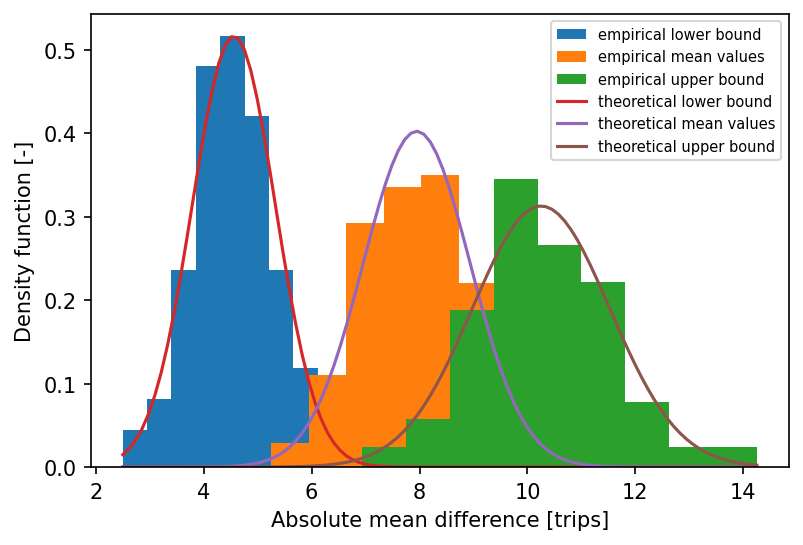

In [6]:
plt.figure(dpi=150)
xs = np.linspace(min(list(mins[:, 4]) + list(means[:, 4]) + list(maxs[:, 4])),
                 max(list(mins[:, 4]) + list(means[:, 4]) + list(maxs[:, 4])), 100)
plt.hist(mins[:, 4], density=True, label='empirical lower bound', bins=9)
plt.hist(means[:, 4], density=True, label='empirical mean values', bins=9)
plt.hist(maxs[:, 4], density=True, label='empirical upper bound', bins=9)
plt.plot(xs, stats.norm.pdf(xs, *stats.norm.fit(mins[:, 4])), label='theoretical lower bound')
plt.plot(xs, stats.norm.pdf(xs, *stats.norm.fit(means[:, 4])), label='theoretical mean values')
plt.plot(xs, stats.norm.pdf(xs, *stats.norm.fit(maxs[:, 4])), label='theoretical upper bound')
plt.legend(fontsize=7, loc='upper right')
plt.xlabel('Absolute mean difference [trips]', fontsize=10)
plt.ylabel('Density function [-]', fontsize=10)
plt.show()

In [22]:
sample_stats(mins[:, 4])

{'min': 2.5,
 'max': 6.562,
 'mean': 4.558,
 'std': 0.772,
 'kv': 0.1695,
 'var': 0.597,
 'u_alpha': 1.645,
 'error': 0.228,
 'size': 31.0}

In [23]:
sample_stats(means[:, 4])

{'min': 5.25,
 'max': 11.5,
 'mean': 7.947,
 'std': 0.991,
 'kv': 0.1247,
 'var': 0.983,
 'u_alpha': 1.645,
 'error': 0.397,
 'size': 17.0}

In [24]:
sample_stats(maxs[:, 4])

{'min': 6.938,
 'max': 14.25,
 'mean': 10.251,
 'std': 1.275,
 'kv': 0.1244,
 'var': 1.626,
 'u_alpha': 1.645,
 'error': 0.513,
 'size': 17.0}

{'chi2': 9.7158, 'test': 12.5916, 'df': 6}

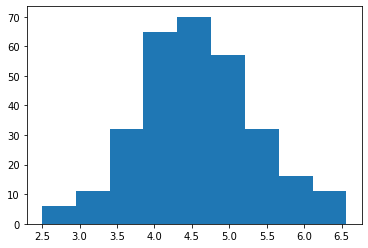

In [25]:
chi_square_norm(mins[:, 4])

{'chi2': 5.6371, 'test': 12.5916, 'df': 6}

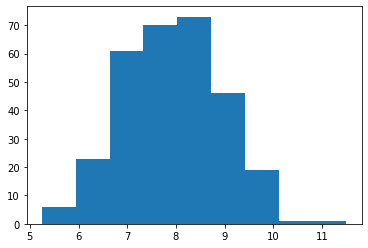

In [26]:
chi_square_norm(means[:, 4])

{'chi2': 18.8843, 'test': 12.5916, 'df': 6}

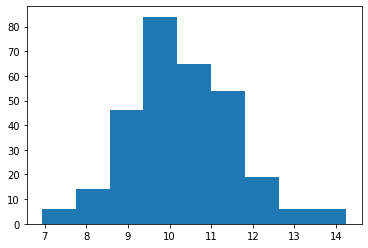

In [27]:
chi_square_norm(maxs[:, 4])